In [1]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1. Load the Diabetes Dataset

In [2]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("diabetes.csv")

# Display the first few rows
print(df.head())

   Number of times pregnant  \
0                         6   
1                         1   
2                         8   
3                         1   
4                         0   

   Plasma glucose concentration a 2 hours in an oral glucose tolerance test  \
0                                                148                          
1                                                 85                          
2                                                183                          
3                                                 89                          
4                                                137                          

   Diastolic blood pressure (mm Hg)  Triceps skin fold thickness (mm)  \
0                                72                                35   
1                                66                                29   
2                                64                                 0   
3                                66           

### Check for missing value

In [3]:
# Check for missing values
print(df.isnull().sum())

Number of times pregnant                                                    0
Plasma glucose concentration a 2 hours in an oral glucose tolerance test    0
Diastolic blood pressure (mm Hg)                                            0
Triceps skin fold thickness (mm)                                            0
2-Hour serum insulin (mu U/ml)                                              0
Body mass index (weight in kg/(height in m)^2)                              0
Diabetes pedigree function                                                  0
Age (years)                                                                 0
Class variable                                                              0
dtype: int64


### Handle Missing Values Represented as Zeros

In [4]:
# Columns where zero values make no sense and indicate missing data
cols_with_zero = [
    "Plasma glucose concentration a 2 hours in an oral glucose tolerance test",
    "Diastolic blood pressure (mm Hg)",
    "Triceps skin fold thickness (mm)",
    "2-Hour serum insulin (mu U/ml)",
    "Body mass index (weight in kg/(height in m)^2)",
]

# Replace zeros with NaN
for col in cols_with_zero:
    df[col] = df[col].replace(0, np.nan)

# Check the number of missing values again
print(df.isnull().sum())

Number of times pregnant                                                      0
Plasma glucose concentration a 2 hours in an oral glucose tolerance test      5
Diastolic blood pressure (mm Hg)                                             35
Triceps skin fold thickness (mm)                                            227
2-Hour serum insulin (mu U/ml)                                              374
Body mass index (weight in kg/(height in m)^2)                               11
Diabetes pedigree function                                                    0
Age (years)                                                                   0
Class variable                                                                0
dtype: int64


### Impute Missing Values

In [5]:
# Impute missing values with median
df.fillna(df.median(), inplace=True)

# Verify that there are no more missing values
print(df.isnull().sum())

Number of times pregnant                                                    0
Plasma glucose concentration a 2 hours in an oral glucose tolerance test    0
Diastolic blood pressure (mm Hg)                                            0
Triceps skin fold thickness (mm)                                            0
2-Hour serum insulin (mu U/ml)                                              0
Body mass index (weight in kg/(height in m)^2)                              0
Diabetes pedigree function                                                  0
Age (years)                                                                 0
Class variable                                                              0
dtype: int64


## 2. Preprocess the Data

### Separate Features and Target Variable

In [6]:
# Separate features (X) and target variable (y)
X = df.drop("Class variable", axis=1)
y = df["Class variable"]

### Split the Data into Training and Test Sets

In [7]:
from sklearn.model_selection import train_test_split

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Standardize the Features

In [8]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3. Apply Cross-Validation and Hyperparameter Tuning

### Set Up a Random Forest Classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

### Implement Grid Search with Cross-Validation

In [10]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid to search
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "max_features": ["sqrt", "log2"],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1, scoring="accuracy"
)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}


### Train the Model Using the Best Parameters

In [11]:
# Get the best estimator
best_rf = grid_search.best_estimator_

## 4. Implement Ensemble Learning

### Initialize Individual Classifiers

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Initialize the classifiers with default hyperparameters
log_clf = LogisticRegression(random_state=42, max_iter=1000)
svc_clf = SVC(probability=True, random_state=42)

### Create the Voting Classifier

In [13]:
from sklearn.ensemble import VotingClassifier

# Combine classifiers into a voting classifier
voting_clf = VotingClassifier(
    estimators=[("rf", best_rf), ("lr", log_clf), ("svc", svc_clf)],
    voting="soft",  # Use soft voting to consider predicted probabilities
)

### Train the Ensemble Model

In [14]:
# Fit the ensemble model on the training data
voting_clf.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

### Predict on the Test Set

In [15]:
# Predictions from the ensemble model
y_pred_voting = voting_clf.predict(X_test_scaled)

## Train Individual Models for Comparison

### Random Forest

In [16]:
# Predictions from the Random Forest model
y_pred_rf = best_rf.predict(X_test_scaled)

### Logistic Regression

In [17]:
# Fit and predict with Logistic Regression
log_clf.fit(X_train_scaled, y_train)
y_pred_log = log_clf.predict(X_test_scaled)

### Support Vector Machine

In [18]:
# Fit and predict with SVM
svc_clf.fit(X_train_scaled, y_train)
y_pred_svc = svc_clf.predict(X_test_scaled)

## 5. Evaluate and Compare Models

### Import Evaluation Metrics

In [19]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
)
import matplotlib.pyplot as plt

### Compute Metrics for Each Model

In [20]:
models = {
    "Random Forest": (best_rf, y_pred_rf),
    "Logistic Regression": (log_clf, y_pred_log),
    "Support Vector Machine": (svc_clf, y_pred_svc),
    "Voting Classifier": (voting_clf, y_pred_voting),
}

# Initialize a results dictionary
results = {}

for model_name, (model, y_pred) in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Check if the model has predict_proba or decision_function method
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    elif hasattr(model, "decision_function"):
        y_pred_scores = model.decision_function(X_test_scaled)
        roc_auc = roc_auc_score(y_test, y_pred_scores)
    else:
        roc_auc = "N/A"  # Not applicable

    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC-AUC": roc_auc,
    }

# Create a DataFrame to display the results
results_df = pd.DataFrame(results).T
print(results_df)

                        Accuracy  Precision    Recall  F1 Score   ROC-AUC
Random Forest           0.733766   0.625000  0.636364  0.630631  0.834068
Logistic Regression     0.753247   0.666667  0.618182  0.641509  0.822773
Support Vector Machine  0.746753   0.666667  0.581818  0.621359  0.808632
Voting Classifier       0.759740   0.673077  0.636364  0.654206  0.837282


### Visualize ROC Curves

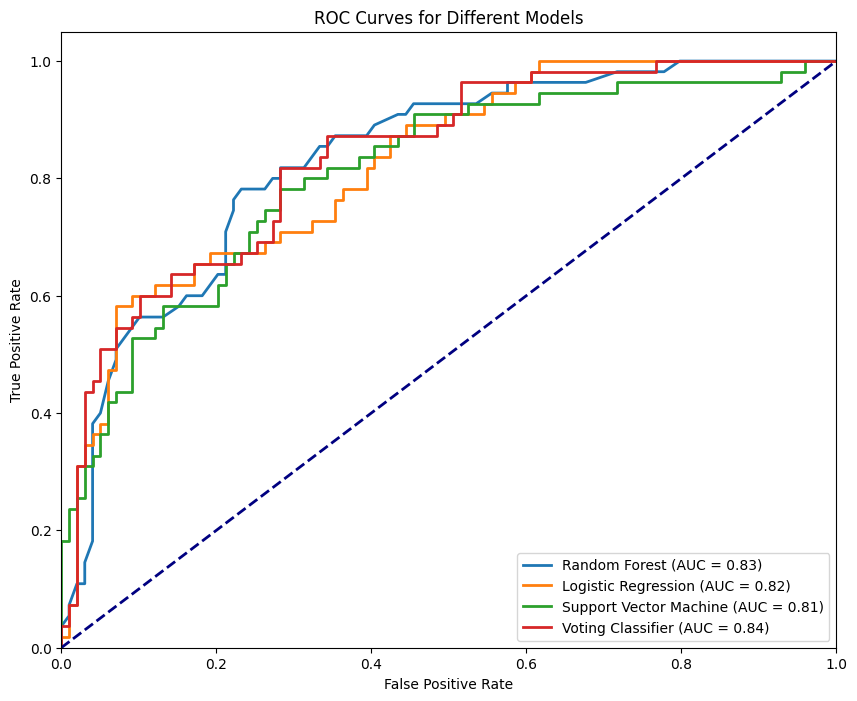

In [21]:
plt.figure(figsize=(10, 8))

for model_name, (model, _) in models.items():
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        # For SVM
        y_pred_proba = model.decision_function(X_test_scaled)
    else:
        continue  # Skip if no probability scores are available

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label="%s (AUC = %0.2f)" % (model_name, roc_auc))

# Plot chance line
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Models")
plt.legend(loc="lower right")
plt.show()

## Discussion
Based on the evaluation metrics and ROC curves:

- Random Forest and Voting Classifier models have slightly higher accuracy and ROC-AUC scores compared to individual models like Logistic Regression and SVM.
- The Voting Classifier combines the strengths of different algorithms, which can lead to better overall performance.
- The Random Forest model performs well due to its ability to handle complex interactions between features.